# 1D diffusion eq. solved with Physics Informed Neural Network(PINN)

Reference: 山田涼平 MSc thesis "Physics-Informed Neural Network を用いたデータ駆動型流体解析のネットワーク設計指針"

## Physical Model
The following shows the differential equation, initial conditions, and boundary conditions used in this study.  
・Governing Equation  
$$
\frac{∂u}{\partial t} = \kappa\frac{\partial^2 u}{\partial x^2}
$$  
・Initial Condition: $u(t=0, x) = \sin{a\pi x}\ \mathrm{where}\ 0\leq x\leq 1$  
・Boundary Condition: $u(t,x=0) = u(t, x=1) = 0\ \mathrm{where}\ 0\leq t$  
Here, $x$ denotes the spatial coordinate, $t$ is time, $u(t,x)$ is the physical quantity, $\kappa$ is the diffusion coefficient, and $a$ is an arbitrary constant.  
This equation admits an exact solution via separation of variables:  
$$\nu(x,t) = \sin{a\pi x} \times \exp({-a^2\pi^2\kappa t})$$  
This exact solution will be used as the ground truth for training and performance testing of the neural network.


## Loss Function
The following function $\mathrm{Loss}(u)$ is used as the loss function:
$$
\mathrm{Loss}(u)=\frac{1}{N_f}\Sigma^{N_f}_{i=1}||f(u(t_i, x_i))||^2 + \frac{1}{N_b}\Sigma^{N_b}_{i=1}||u^{boundary}_i-u(t_i,x_i)||^2 + \frac{1}{N_i}\Sigma^{N_i}_{i=1}||u^{initial}_i-u(t_i,x_i)||^2 \\\\
f(u(t,x))=\frac{∂u}{\partial t} - \kappa\frac{\partial^2 u}{\partial x^2}
$$
The three terms in this loss function respectively evaluate the consistency with the governing equation, the boundary condition, and the initial condition.  
When $\mathrm{Loss}(u)$ converges to 0, each term on the right-hand side also converges to 0. Thus, by minimizing this loss function, the output satisfies all of the physical constraints. In other words, the neural network learns the physics.  
Note that each term on the right-hand side is calculated for the domain interior, the boundary, and the initial condition, respectively. Be aware that the points $(t_i, x_i)$ differ across these terms.


# Import Libraries


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import datetime

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Setting Parameters

In [15]:
# Parameters for diffusion eq.
kappa = 0.05 # diffusion coefficient
a = 2  # parameter for initial condition

# grid parameters
nx_train = 100
nt_train = 100

nx_test = 500
nt_test = 500

epochs = 15000  # number of epochs
learning_ratio = 0.0001  # training rate

seed = 42  # seed for random

PI = np.pi

visualize the exact solution

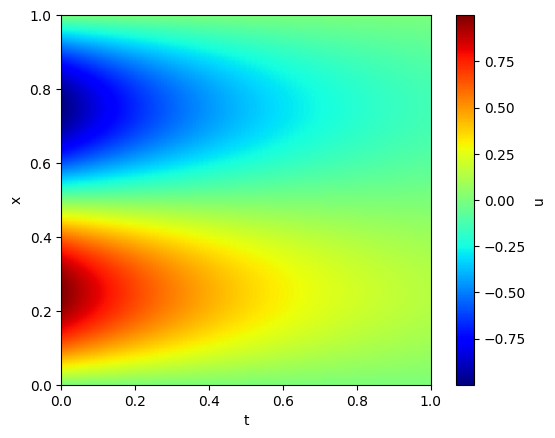

In [16]:
x = np.linspace(0, 1, 500)
t = np.linspace(0, 1, 100)
tg, xg = np.meshgrid(x, t, indexing="ij")
u_true = np.sin(a*PI*xg) * np.exp(-a**2*PI**2*kappa*tg) #exact solution

fig, ax = plt.subplots()
img = ax.pcolormesh(tg, xg, u_true, shading="gouraud", cmap="jet")
cbar = fig.colorbar(img, ax=ax)
cbar.set_label("u")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_aspect("equal")

# Preparation for Training

## Generation of Training data
The training points for the neural network are uniformly generated for the domain interior, boundary, and initial condition regions.
Here, equally-distributed (i.e., uniformly-gridded) points are used for clarity, but randomly-distributed points can also be used (mesh-free).

(-0.05, 1.05)

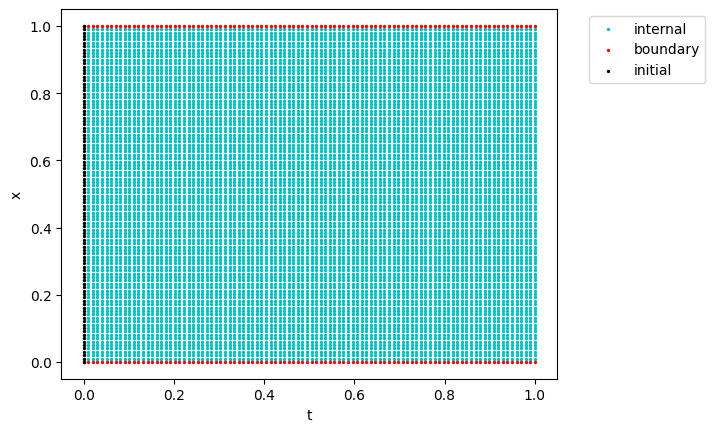

In [17]:
# generating sampling points
x = np.linspace(0, 1, nx_train)
t = np.linspace(0, 1, nt_train)

# internal points
x_fg, t_fg = np.meshgrid(x[1:-1], t[1:], indexing="ij")
x_f = x_fg.reshape(-1, 1)
t_f = t_fg.reshape(-1, 1)

# boundary points
x_b0 = np.zeros(shape=nt_train)
x_b1 = np.ones(shape=nt_train)
x_b = np.concatenate([x_b0, x_b1])
t_b = np.concat([t, t])

# initial points
x_i = x
t_i = np.zeros(shape=nx_train)

# Plot of sampling points
fig, ax = plt.subplots()
labels = ["internal", "boundary", "initial"]
colors = ["c", "r", "k"]
t_list = [t_f, t_b, t_i]
x_list = [x_f, x_b, x_i]
s = 2.0
for t, x, label, color in zip(t_list, x_list, labels, colors):
  ax.scatter(t, x, label=label, c=color, s=s)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

convert numpy-type variables into tensor-type ones using torch.tensor

In [18]:
x_f = torch.tensor(x_f, dtype=torch.float, requires_grad=True)
t_f = torch.tensor(t_f, dtype=torch.float, requires_grad=True)

x_b = torch.tensor(x_b, dtype=torch.float, requires_grad=True)
t_b = torch.tensor(t_b, dtype=torch.float, requires_grad=True)

x_i = torch.tensor(x_i, dtype=torch.float, requires_grad=True)
t_i = torch.tensor(t_i, dtype=torch.float, requires_grad=True)


u_true_b = torch.sin(a*PI*x_b) * torch.exp(-a**2*PI**2*kappa*t_b)
u_true_b = u_true_b.reshape(-1, 1).detach()
u_true_i = torch.sin(a*PI*x_i) * torch.exp(-a**2*PI**2*kappa*t_i)
u_true_i = u_true_i.reshape(-1, 1).detach()

## Define functions for training


### Loss function

In [19]:
class PhysicsInformedLoss(nn.Module):
  def __init__(self, kappa):
    super().__init__()
    self.mseloss = nn.MSELoss()
    self.kappa = kappa


  def pde_informed_loss(self, t, x, u_pred):
    dudt = torch.autograd.grad(u_pred, t_f, grad_outputs=torch.ones_like(u_pred), create_graph=True, retain_graph=True)[0]
    dudx = torch.autograd.grad(u_pred, x_f, grad_outputs=torch.ones_like(u_pred), create_graph=True, retain_graph=True)[0]
    dudx2 = torch.autograd.grad(dudx, x_f, grad_outputs=torch.ones_like(dudx), retain_graph=True)[0]
    return self.mseloss(dudt, self.kappa*dudx2)


  def forward(self,
              t_f,
              x_f,
              u_pred_internal,
              u_pred_b,
              u_pred_i,
              u_true_b,
              u_true_i):

    loss = (
        self.pde_informed_loss(t_f, x_f, u_pred_internal)
        + self.mseloss(u_pred_b, u_true_b)
        + self.mseloss(u_pred_i, u_true_i)
        )
    return loss

### Define class for NN training

In [20]:
class TrainPINN(nn.Module):
  def __init__(self, loss_fn, opt, epochs):
    super().__init__()
    self.loss_fn = loss_fn
    self.opt = opt
    self.epochs = epochs

  def prediction(self, model, t, x):
    return model(torch.stack([t, x], axis=-1))

  def train_model(
      self,
      model,
      t_f,
      x_f,
      t_b,
      x_b,
      t_i,
      x_i,
      u_true_b,
      u_true_i,
      ):
    loss_list = []
    for epoch in range(self.epochs):
      model.train()
      self.opt.zero_grad()
      u_pred_f = self.prediction(model, t_f, x_f)
      u_pred_b = self.prediction(model, t_b, x_b)
      u_pred_i =  self.prediction(model, t_i, x_i)
      loss = self.loss_fn(
          t_f,
          x_f,
          u_pred_f,
          u_pred_b,
          u_pred_i,
          u_true_b,
          u_true_i)

      loss.backward()
      self.opt.step()
      loss_list.append(loss.item())
    return loss_list

  def plot_loss(self, loss_list):
    x_axis = np.arange(1, self.epochs+1)
    fig, ax = plt.subplots()
    ax.plot(x_axis, loss_list)
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")

## Construct PINN model

In [21]:
pinn = nn.Sequential(
    nn.Linear(2, 5),
    nn.Tanh(),
    # nn.ReLU(),
    nn.Linear(5, 5),
    nn.Tanh(),
    # nn.ReLU(),
    nn.Linear(5, 5),
    nn.Tanh(),
    # nn.ReLU(),
    nn.Linear(5, 1)
)

show model abstract using summery() function in torch_summery library

In [22]:
summary(pinn, input_size=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 5]              15
              Tanh-2                    [-1, 5]               0
            Linear-3                    [-1, 5]              30
              Tanh-4                    [-1, 5]               0
            Linear-5                    [-1, 5]              30
              Tanh-6                    [-1, 5]               0
            Linear-7                    [-1, 1]               6
Total params: 81
Trainable params: 81
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Training

Elapsed time = 168.287143 sec


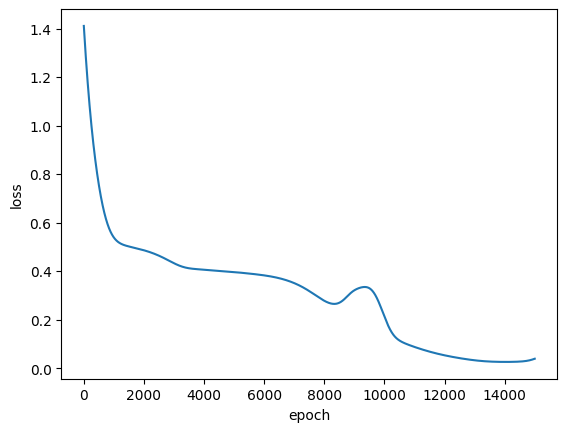

In [23]:
torch.manual_seed(seed)

loss_fn = PhysicsInformedLoss(kappa)
opt = torch.optim.Adam(pinn.parameters(), lr=learning_ratio)

train_pinn = TrainPINN(loss_fn, opt, epochs)

start = datetime.datetime.now()
train_loss = train_pinn.train_model(
    pinn,
    t_f,
    x_f,
    t_b,
    x_b,
    t_i,
    x_i,
    u_true_b,
    u_true_i,
    )
end = datetime.datetime.now()
print(f"Elapsed time = {(end - start).total_seconds()} sec")

train_pinn.plot_loss(train_loss)

# Performance evaluation of NN

Evaluate the prediction time and accuracy of the trained PINN

In this study, the prediction accuracy is evaluated using the Root Mean Squared Error (RMSE) between the predicted values and the exact solution, as given by the following formula:
$$
\mathrm{RMSE}=\sqrt{\frac{1}{N}\Sigma^{N}_{i=1}(u^{true}_i-u^{prediction}_i)^2}
$$
Here, N is the total number of grid points, $u^{true}_i$ is the exact solution at the i-th point, and $u^{prediction}_i$ is the predicted value at the i-th point.


In [24]:
x_test = np.linspace(0, 1, nx_test)
t_test = np.linspace(0, 1, nt_test)
tg, xg = np.meshgrid(t_test, x_test, indexing="ij")
input_test = np.stack([tg, xg], axis=-1).reshape(-1, 2)
input_test = torch.tensor(input_test, dtype=torch.float, requires_grad=True)
u_true_test = torch.sin(a*PI*input_test[:, 1]) * torch.exp(-a**2*PI**2*kappa*input_test[:, 0])
u_true_test = u_true_test.reshape(len(u_true_test), 1)

start = datetime.datetime.now()
u_pred_test = pinn(input_test)
end = datetime.datetime.now()
print(f"Elapsed time = {(end - start).total_seconds()} sec")
rmse_pinn  = torch.sqrt(F.mse_loss(u_true_test, u_pred_test))
print(f"rmse = {rmse_pinn: .4f}")

Elapsed time = 0.03869 sec
rmse =  0.0376


# Comparison with Numerical Simulation
We compare the computation time and prediction accuracy between the explicit finite difference method and the neural network.

For the diffusion equation, the following stability condition is derived from the von Neumann stability analysis:
$$
d = \frac{\kappa \, dt}{dx^2} < \frac{1}{2}
$$
Here, $dt$ is a dimensionless number called the diffusion number, $dt$ is the time step, $dt$ is the grid spacing, and $\kappa$ is the diffusion coefficient.  
In this study, the same spatial coordinates used during PINN training are employed, and $dt$ is chosen such that $d=0.25$.

The first-order Euler method is used for time integration, and the second-order central difference method is used for spatial discretization.  
To compare the neural network predictions with the numerical results at the same spatial locations, temporal interpolation is performed on the numerical results to obtain data at the time steps used in the PINN prediction.


In [25]:
d = 0.25
dx = 1 / nx_test
dt = d * (dx ** 2 / kappa)

t_num = np.arange(0, 1+2*dt, dt)
nt_num = len(t_num)
nx_num = nx_test
u_num = np.zeros(shape=(nt_num, nx_num))
u_num[0, :] = np.sin(a*PI*x_test)

start = datetime.datetime.now()
for i in range(nt_num-1):
  for j in range(1, nx_num-1):
    u_num[i+1, j] = u_num[i, j] + kappa * dt * (u_num[i, j+1] - 2 * u_num[i, j] + u_num[i, j-1]) / dx**2
end = datetime.datetime.now()
print(f"Elapsed time = {(end - start).total_seconds()} sec")

interpolater = scipy.interpolate.interp1d(t_num, u_num, axis=0)
u_num_test = interpolater(t_test)

u_num_test_torch = torch.tensor(u_num_test.reshape(-1, 1), dtype=torch.float)

rmse_num = torch.sqrt(F.mse_loss(u_true_test, u_num_test_torch))
print(f"rmse = {rmse_num.item():.4f}")

Elapsed time = 54.02259 sec
rmse = 0.0009


Plot figures (Ground Truth, PINN result, CFD result)

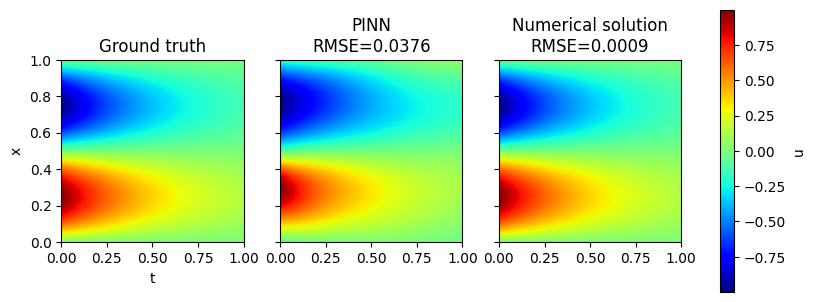

In [26]:
fig, axes = plt.subplots(1, 3,figsize=[10, 10], sharey=True)
axes_list = axes.ravel().tolist()
tg, xg = np.meshgrid(t_test, x_test, indexing="ij")
u_list = [u_true_test.reshape(nt_test, nx_test).detach().numpy(), u_pred_test.reshape(nt_test, nx_test).detach().numpy(), u_num_test]
labels = ["Ground truth", f"PINN\nRMSE={rmse_pinn.item():.4f}", f"Numerical solution\nRMSE={rmse_num.item():.4f}"]



for ax, u, label in zip(axes_list, u_list, labels):
  img = ax.pcolormesh(tg, xg, u, shading="gouraud", cmap="jet")
  ax.set_title(label)
  ax.set_aspect("equal")

  if ax == axes_list[0]:
    ax.set_xlabel("t")
    ax.set_ylabel("x")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

  if ax == axes_list[-1]:
    cbar = fig.colorbar(img, ax=axes_list, orientation="vertical")
    cbar.set_label("u")
    axpos = ax.get_position()
    caxpos = cbar.ax.get_position()
    cbar.ax.set_position([caxpos.x0, axpos.y0-0.05, caxpos.width, axpos.height+0.1])